# FIRE

In [1]:
# https://www.kaggle.com/code/noorabuzanouneh/ai-vs-real-file

In [2]:
# Чтобы не вылетала ошибка Kernel Error при построении графиков в matplotlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset

from transformers import pipeline
from torchvision.transforms.functional import to_pil_image
import diffusers

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import DatasetFolder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torch.nn.functional as F

import sys
import pkg_resources

<ipython-input-3-b8c92f78d842>:24: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_INFERENCE_STEPS = 50
TIMESTEPS = 20

## 1. Prepare the BLIP annotations 

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yangsangtai/tiny-genimage")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tiny-genimage


In [6]:
# !mv /root/.cache/kagglehub/datasets/yangsangtai/tiny-genimage/versions/1 /content/dataset

In [83]:
def collect_image_paths(root_dirs):
    """Collects image paths from the given directory list."""
    image_paths = []
    for root_dir in root_dirs:
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(subdir, file))
    return image_paths

class SimpleCustomDataset(Dataset):
    """Custom Dataset for loading directly from image paths, labels, and returning paths."""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label, image_path


class SimpleCustomBLIPDataset(Dataset):
    """Custom Dataset for loading directly from image paths, labels, and returning paths."""
    def __init__(self, image_paths, labels, blip_input, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.blip_input = blip_input

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        blip_output = self.blip_input[self.blip_input['image_path'] == image_path]['blip'].item()

        return image, label, image_path, blip_output 

# Define transformations
transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.RandomRotation(15),
    # transforms.RandomResizedCrop(256),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # transforms.ToPILImage(),
])

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [84]:
ai_paths_train = [
    # "/kaggle/input/tiny-genimage/imagenet_ai_0419_biggan/train/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0419_vqdm/train/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/train/ai",
    # "/kaggle/input/tiny-genimage/imagenet_ai_0424_wukong/train/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0508_adm/train/ai",
    "/kaggle/input/tiny-genimage/imagenet_glide/train/ai",
    "/kaggle/input/tiny-genimage/imagenet_midjourney/train/ai"
]

nature_paths_train = [
    # "/kaggle/input/tiny-genimage/imagenet_ai_0419_biggan/train/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0419_vqdm/train/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/train/nature",
    # "/kaggle/input/tiny-genimage/imagenet_ai_0424_wukong/train/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0508_adm/train/nature",
    "/kaggle/input/tiny-genimage/imagenet_glide/train/nature",
    "/kaggle/input/tiny-genimage/imagenet_midjourney/train/nature"
]

# Paths for validation data
ai_paths_val = [
    # "/kaggle/input/tiny-genimage/imagenet_ai_0419_biggan/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0419_vqdm/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/val/ai",
    # "/kaggle/input/tiny-genimage/imagenet_ai_0424_wukong/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0508_adm/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_glide/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_midjourney/val/ai"
]

nature_paths_val = [
    # "/kaggle/input/tiny-genimage/imagenet_ai_0419_biggan/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0419_vqdm/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/val/nature",
    # "/kaggle/input/tiny-genimage/imagenet_ai_0424_wukong/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0508_adm/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_glide/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_midjourney/val/nature"
]

# Collect image paths
ai_image_paths_train = collect_image_paths(ai_paths_train)
nature_image_paths_train = collect_image_paths(nature_paths_train)
ai_image_paths_val = collect_image_paths(ai_paths_val)
nature_image_paths_val = collect_image_paths(nature_paths_val)

# Labels for the images (0 for AI, 1 for nature)
ai_labels_train = [0] * len(ai_image_paths_train)
nature_labels_train = [1] * len(nature_image_paths_train)
ai_labels_val = [0] * len(ai_image_paths_val)
nature_labels_val = [1] * len(nature_image_paths_val)

# Combine image paths and labels
train_image_paths = ai_image_paths_train + nature_image_paths_train
train_labels = ai_labels_train + nature_labels_train
val_image_paths = ai_image_paths_val + nature_image_paths_val
val_labels = ai_labels_val + nature_labels_val


In [ ]:
# Create the dataset for BLIP training
# train_dataset = SimpleCustomDataset(train_image_paths, train_labels, transform=transform1)
# val_dataset = SimpleCustomDataset(val_image_paths, val_labels, transform=transform1)

# DataLoader setup
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

In [70]:
# Preilminary trained the blip-inputs:

# from tqdm import tqdm
# pipe = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base", device="cuda:0")
# COLUMN_NAMES = ['image_path', 'blip']
# df_blip_val = pd.DataFrame(columns=COLUMN_NAMES)
# for images, labels, image_path in tqdm(val_loader):
#     images = images.to("cuda")
#     blip_output = pipe(to_pil_image(images[0]))
#     # custom_label = [blip['generated_text'] for blip in blip_output]
#     df_temp = pd.DataFrame({COLUMN_NAMES[0]: [image_path[0]], COLUMN_NAMES[1]: [blip_output[0]['generated_text']]})
#     df_blip_val = pd.concat([df_blip_val, df_temp], ignore_index=True)


Device set to use cuda:0
100%|██████████| 5000/5000 [17:23<00:00,  4.79it/s]


In [76]:
# df_blip.drop_duplicates(subset=['image_path'], inplace=True)
# df_blip_val.drop_duplicates(subset=['image_path'], inplace=True)
# df_blip.to_csv("blip_full.csv", index=False)
# df_blip_val.to_csv("blip_val_full.csv", index=False)

In [80]:
# df_blip_train = pd.read_csv('/kaggle/working/blip_full.csv')
# df_blip_val = pd.read_csv('/kaggle/working/blip_val_full.csv')

## 2. Prepare the data

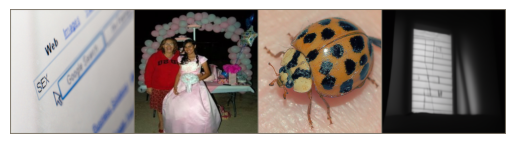

In [85]:
# Create the dataset
train_dataset = SimpleCustomBLIPDataset(train_image_paths, train_labels, blip_input=df_blip_train, transform=transform2)
val_dataset = SimpleCustomBLIPDataset(val_image_paths, val_labels, blip_input=df_blip_val, transform=transform2)

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Visualization function
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get a batch of images and labels
images, labels, image_path, blip_output = next(iter(train_loader))  # Note: Change to train_loader
out = torchvision.utils.make_grid(images)
imshow(out)

In [100]:
[('REAL' if klass == 1 else 'FAKE') for klass in labels.tolist()]

['REAL', 'REAL', 'REAL', 'FAKE']

In [101]:
image_path

('/kaggle/input/tiny-genimage/imagenet_midjourney/train/nature/n06359193_20739.JPEG',
 '/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/train/nature/n03534580_13343.JPEG',
 '/kaggle/input/tiny-genimage/imagenet_midjourney/train/nature/n02165456_15810.JPEG',
 '/kaggle/input/tiny-genimage/imagenet_glide/train/ai/GLIDE_1000_200_09_905_glide_00129.png')

In [102]:
blip_output

('a close up of a computer screen with a keyboard',
 'two girls in pink dresses standing next to a table',
 "a lady beetle on a human ' s skin",
 'a window with a curtain and a light coming through it')

## 3. Building the model

In [104]:
# import diffusers
# from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents
# pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None)
torch.cuda.empty_cache()

In [87]:
# def calculate_reconstruction(vae, initial_images):
#     # from tqdm import tqdm
#     decode_dtype = next(iter(vae.post_quant_conv.parameters())).dtype
#     reconstruction = torch.zeros(initial_images.shape)
#     for i in range(initial_images.shape[0]):

#       latents_initial_images = retrieve_latents(vae.encode(initial_images[i:i+1].to(decode_dtype).to(device)))
#       reconstruction = vae.decode(latents_initial_images.to(decode_dtype),return_dict=False)[0]

#     return reconstruction

In [88]:
import torch.nn as nn
from torch import Tensor
from typing import Literal
import math
import torch, torchvision, diffusers
from typing import *
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import (
    retrieve_latents,
)


def get_resnet_model(mode: Literal["rgb", "ours"], norm_layer: Literal["batch", "instance"], pretrained: bool) -> nn.Module:

    if norm_layer == "batch":
        norm = nn.BatchNorm2d
    elif norm_layer == "instance":
        norm = nn.InstanceNorm2d
    else:
        raise AssertionError("Unknown norm layer")

    if norm == nn.InstanceNorm2d:
        model = torchvision.models.resnet50(num_classes=1000, pretrained=False, norm_layer=norm)
        model.load_state_dict(torchvision.models.ResNet50_Weights.IMAGENET1K_V2.get_state_dict(progress=True, check_hash=True), strict=False)
    else:
        model = torchvision.models.resnet50(num_classes=1000, weights="IMAGENET1K_V2", norm_layer=norm)

    if mode == "ours":
        model.conv1.weight = nn.Parameter(torch.cat([model.conv1.weight * 0.25] * 4, dim=1))
        model.conv1.in_channels = 12

    model.fc = nn.Linear(2048, 1)
    torch.nn.init.normal_(model.fc.weight.data, 0.0, 0.02)

    return model

def get_frq_resnet_model(mode: Literal["rgb", "ours", "frq"], norm_layer: Literal["batch", "instance"], pretrained: bool) -> nn.Module:

    if norm_layer == "batch":
        norm = nn.BatchNorm2d
    elif norm_layer == "instance":
        norm = nn.InstanceNorm2d
    else:
        raise AssertionError("Unknown norm layer")

    if norm == nn.InstanceNorm2d:
        model = torchvision.models.resnet50(num_classes=1000, pretrained=False, norm_layer=norm)
        model.load_state_dict(torchvision.models.ResNet50_Weights.IMAGENET1K_V2.get_state_dict(progress=True, check_hash=True), strict=False)
    else:
        model = torchvision.models.resnet50(num_classes=1000, weights="IMAGENET1K_V2", norm_layer=norm)

    if mode == "frq":
        model.conv1.weight = nn.Parameter(torch.cat([model.conv1.weight * 0.25] * 2, dim=1))
        model.conv1.in_channels = 6

    model.fc = nn.Linear(2048, 1)
    torch.nn.init.normal_(model.fc.weight.data, 0.0, 0.02)

    return model

class ESPCN(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            channels: int,
            upscale_factor: int,
    ) -> None:
        super(ESPCN, self).__init__()
        hidden_channels = channels // 2
        out_channels = int(out_channels * (upscale_factor ** 2))
        self.bn = nn.BatchNorm2d(in_channels)
        # Feature mapping
        self.feature_maps = nn.Sequential(
            nn.Conv2d(in_channels, channels, (5, 5), (1, 1), (2, 2)),
            nn.Tanh(),
            nn.Conv2d(channels, hidden_channels, (3, 3), (1, 1), (1, 1)),
            nn.Tanh(),
        )

        # Sub-pixel convolution layer
        self.sub_pixel_0 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upscale_factor),
            nn.Sigmoid(),
        )

        self.sub_pixel_1 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upscale_factor),
            nn.Sigmoid(),
        )

        # Initial model weights
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                if module.in_channels == 32:
                    nn.init.normal_(module.weight.data,
                                    0.0,
                                    0.001)
                    nn.init.zeros_(module.bias.data)
                else:
                    nn.init.normal_(module.weight.data,
                                    0.0,
                                    math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                    nn.init.zeros_(module.bias.data)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.bn(x)
        x = self.feature_maps(x)
        x_h = self.sub_pixel_0(x)
        x_l = self.sub_pixel_1(x)

        return x_h, x_l

# def create_vae():
#     # create SD pipeline as usual
#     pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
#                                                              torch_dtype=torch.float16, safety_checker=None)
#     vae = pipe.vae
#     del pipe
#     torch.cuda.empty_cache()

#     return vae


def create_pipeline():
    # create SD pipeline as usual
    pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
                                                             torch_dtype=torch.float16, safety_checker=None)
    vae = pipe.vae
    text_encoder = pipe.text_encoder
    tokenizer = pipe.tokenizer
    unet = pipe.unet
    scheduler = pipe.scheduler
    del pipe

    torch.cuda.empty_cache()

    return vae, text_encoder, tokenizer, unet, scheduler

class FIRE_model(nn.Module):
    def __init__(self, mode="frq", norm_layer="instance", pretrained=True, radiuslow=40, radiushigh=120):
        super(FIRE_model, self).__init__()
        # initialize VAE in the DM
        self.vae, self.text_encoder, self.tokenizer, self.unet, self.scheduler = create_pipeline()
        self.decode_dtype = next(iter(self.vae.post_quant_conv.parameters())).dtype

        for param in self.vae.parameters():
            param.requires_grad = False

        # backend classifier
        self.resnet = get_frq_resnet_model(mode=mode, norm_layer=norm_layer, pretrained=pretrained)
        # FMRE module
        self.fft_filter_module = fft_filter(radiuslow=radiuslow, radiushigh=radiushigh, rows=IMAGE_SIZE, cols=256)
        self.vae = self.vae.to("cuda")

        self.text_encoder = self.text_encoder.to("cuda")
        self.unet = self.unet.to("cuda")
        self.scheduler.set_timesteps(num_inference_steps=NUM_INFERENCE_STEPS)

        self.resnet = self.resnet.to("cuda")
        self.fft_filter_module = self.fft_filter_module.to("cuda")

    def calculate_reconstruction(self, initial_images):
    # from tqdm import tqdm
        decode_dtype = next(iter(self.vae.post_quant_conv.parameters())).dtype
        reconstruction = torch.zeros(initial_images.shape)
        for i in range(initial_images.shape[0]):

          latents_initial_images = retrieve_latents(self.vae.encode(initial_images[i:i+1].to(decode_dtype).to(device)))
          reconstruction = self.vae.decode(latents_initial_images.to(decode_dtype),return_dict=False)[0]

        return reconstruction

    def forward(self, x, blip_label):
        middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd = self.fft_filter_module(x)

        latents_x = retrieve_latents(self.vae.encode(x.to(self.decode_dtype)))

        ### text emb part start
        text_input = self.tokenizer(blip_label, padding="max_length", truncation=True, max_length=self.tokenizer.model_max_length, return_tensors="pt").input_ids
        text_input = text_input.to("cuda")
        text_embedding = self.text_encoder(text_input)[0]
        noise = torch.randn_like(latents_x).to("cuda")
        noisy_latents_x = self.scheduler.add_noise(latents_x, noise, timesteps=torch.tensor(TIMESTEPS))
        noise_pred = self.unet(noisy_latents_x, torch.tensor(TIMESTEPS), encoder_hidden_states=text_embedding).sample
        latents_x_new = self.scheduler.step(noise_pred, torch.tensor(TIMESTEPS), noisy_latents_x).prev_sample
        ### text emb part end

        reconstructions_x = self.vae.decode(latents_x_new.to(self.decode_dtype),return_dict=False)[0]
        # reconstructions_x = self.vae.decode(latents_x.to(self.decode_dtype),return_dict=False)[0]
        # reconstructions_x = self.calculate_reconstruction(x)

        latents_middle_filtered = retrieve_latents(self.vae.encode(middle_filtered_image.to(self.decode_dtype)))

        ### text emb part start
        noise = torch.randn_like(latents_middle_filtered).to("cuda")
        noisy_latents_filtered = self.scheduler.add_noise(latents_middle_filtered, noise, timesteps=torch.tensor(TIMESTEPS))
        noise_pred_filtered = self.unet(noisy_latents_filtered, torch.tensor(TIMESTEPS), encoder_hidden_states=text_embedding).sample
        latents_middle_filtered_new = self.scheduler.step(noise_pred_filtered, torch.tensor(TIMESTEPS), noisy_latents_filtered).prev_sample
        ### text emb part end

        reconstructions_middle_filtered = self.vae.decode(latents_middle_filtered_new.to(self.decode_dtype),return_dict=False)[0]
        # reconstructions_middle_filtered = self.vae.decode(latents_middle_filtered.to(self.decode_dtype),return_dict=False)[0]
        # reconstructions_middle_filtered = self.calculate_reconstruction(middle_filtered_image)

        # o = self.resnet(torch.cat(reconstructions_filterd))
        raw_reconstructions_delta = torch.abs(reconstructions_x - x)
        filtered_reconstructions_delta = torch.abs(reconstructions_middle_filtered - middle_filtered_image)
        o = self.resnet(torch.cat([raw_reconstructions_delta, filtered_reconstructions_delta], dim=1))

        return o, middle_freq_image, raw_reconstructions_delta, mask_mid_frq, mask_mid_filterd


class fft_filter(nn.Module):
    def __init__(self, radiuslow=35, radiushigh=120, rows=IMAGE_SIZE, cols=IMAGE_SIZE):
        super(fft_filter, self).__init__()
        self.radiuslow = radiuslow
        self.radiushigh = radiushigh
        self.rows = rows
        self.cols = cols
        # preset masks M_{mid} and M_{mid_c}
        i_mask, r_i_mask = self.init_mask()
        i_mask, r_i_mask = nn.Parameter(i_mask, requires_grad=False), nn.Parameter(r_i_mask, requires_grad=False)
        self.register_buffer('i_mask', i_mask)
        self.register_buffer('r_i_mask', r_i_mask)
        # # encode and decode frequency mask
        self.mask_autoencoder = ESPCN(in_channels=3, out_channels=1, channels=64, upscale_factor=1)

    def init_mask(self):
        mask = torch.ones((1, self.rows, self.cols), dtype=torch.float32, requires_grad=False)
        crow, ccol = self.rows // 2 , self.cols // 2
        center = [crow, ccol]
        x, y = torch.meshgrid(torch.arange(self.rows), torch.arange(self.cols), indexing='ij')
        mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 < self.radiuslow*self.radiuslow
        mask[:, mask_area] = 0
        mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 >= self.radiushigh*self.radiushigh
        mask[:, mask_area] = 0

        return mask, 1-mask


    # implement FMRE
    def middle_pass_filter(self, image):
        freq_image = torch.fft.fftn(image * 255, dim=(-2, -1))
        freq_image = torch.fft.fftshift(freq_image, dim=(-2, -1))
        mask_mid_frq, mask_mid_filterd = self.mask_autoencoder((20*torch.log(torch.abs(freq_image)+1e-7))/255)
        mask_mid_frq = mask_mid_frq.to(freq_image.dtype)

        middle_freq = freq_image * mask_mid_frq
        middle_freq = torch.fft.ifftshift(middle_freq, dim=(-2, -1))
        masked_image_array = torch.fft.ifftn(middle_freq, dim=(-2, -1))
        z = torch.abs(masked_image_array)
        _min = torch.min(z)
        _max = torch.max(z)
        z = (z)/(_max-_min)
        middle_freq_image = z

        mask_mid_filterd = mask_mid_filterd.to(freq_image.dtype)
        middle_filtered = freq_image * mask_mid_filterd
        middle_filtered = torch.fft.ifftshift(middle_filtered, dim=(-2, -1))
        middle_filtered_array = torch.fft.ifftn(middle_filtered, dim=(-2, -1))
        z = torch.abs(middle_filtered_array)
        _min = torch.min(z)
        _max = torch.max(z)
        z = (z)/(_max-_min)
        middle_filtered_image = z

        return middle_freq_image, middle_filtered_image, mask_mid_frq.to(torch.float32), mask_mid_filterd.to(torch.float32)


    def forward(self, image):
        middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd = self.middle_pass_filter(image)

        return middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd


if __name__ == "__main__":
    # model = ESPCN(3, 1, 64, 2)
    # fft_filter = fft_filter()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = FIRE_model()#.to(device)
    x = torch.randn(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
    y = model(x.to(device), ['random']*BATCH_SIZE)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `No

## 4. Train the model

In [89]:
# model.fft_filter_module.r_i_mask

In [90]:
# Losses preparation
def loss_ce(y_true, y_pred):
    """
    часть функции потерь, которая отвечает за правильность определения fake/не-fake
    """

    loss = torch.nn.BCEWithLogitsLoss(reduction='mean')
    return loss(y_true, y_pred)

def loss_mid_rec(x_mid, delta_x):
    """
    mid-frequency reconstruction alignment loss
    """
    loss = torch.linalg.norm(x_mid - delta_x) ** 2
    return loss

def loss_mask(m_mid, M_mid, m_mid_c, M_mid_c):
    """
    mask refinement loss
    """
    loss = torch.linalg.norm(m_mid - M_mid) ** 2 + torch.linalg.norm(m_mid_c - M_mid_c) ** 2 + torch.linalg.norm(1 - m_mid - m_mid_c) ** 2
    return loss

def loss_total(y_true, y_pred, x_mid, delta_x, m_mid, M_mid, m_mid_c, M_mid_c, lambda0 = 0.2, lambda1=0.2, lambda2 = 0.6):
    return lambda0 * loss_mid_rec(x_mid, delta_x) + lambda1 * loss_mask(m_mid, M_mid, m_mid_c, M_mid_c) + lambda2 * loss_ce(y_true, y_pred)

In [91]:
from torch.cuda.amp import GradScaler, autocast
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def train(model, device, train_loader, optimizer, criterion, epoch, num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, labels, _, blip_train) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.float().to(device).view(-1, 1)

        optimizer.zero_grad()
        with autocast():
            o, middle_freq_image, raw_reconstructions_delta, mask_mid_frq, mask_mid_filterd = model(images, blip_train)
            M_mid, M_mid_c = model.fft_filter_module.i_mask, model.fft_filter_module.r_i_mask
            loss_value = criterion(labels, o, middle_freq_image, raw_reconstructions_delta, mask_mid_frq, M_mid, mask_mid_filterd, M_mid_c)


        # o, middle_freq_image, raw_reconstructions_delta, mask_mid_frq, mask_mid_filterd = model(images)
        # M_mid, M_mid_c = model.fft_filter_module.i_mask, model.fft_filter_module.r_i_mask
        # loss_value = criterion(labels, o, middle_freq_image, raw_reconstructions_delta, mask_mid_frq, M_mid, mask_mid_filterd, M_mid_c)

        loss_value.backward()
        optimizer.step()

        total_loss += loss_value.item()
        if (batch_idx + 1) % 20 == 0 or batch_idx == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss_value.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    return avg_loss


num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, loss_total, epoch, num_epochs)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _, blip_val in val_loader:
            images = images.to(device)
            labels = labels.float().to(device).view(-1, 1)
            outputs = model(images, blip_val)
            predicted = (outputs > 0).float()  # Use 0 as threshold because logits are used
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {validation_accuracy:.2f}%')

    torch.save(model, f"fire_blip_{epoch + 1}.pth")
    torch.save(model.state_dict(), f"fire_blip_{epoch + 1}.weights")

In [ ]:
torch.save(model, "fire.pth")
torch.save(model.state_dict(), "fire.weights")

## 5. Validation

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels, _ in val_loader:
        images = images.to(device)
        labels = labels.float().to(device).view(-1, 1)
        outputs = model(images)
        predicted = (outputs > 0).float()  # Use 0 as threshold because logits are used
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = 100 * correct / total
print(f'Validation Accuracy: {validation_accuracy:.2f}%')